In [ ]:
# Instalar las librerias
#!pip install pandas
#!pip install scikit-learn
# D:\01_MaestriaAnalitica_UnivAndes\07_ML_NLP\S4\Proyecto\pry_pric_cars\venv\Scripts\pip.exe install -r requirements.txt
#!pip install imblearn

In [8]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
import time
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import os

### Analisis Exploratorio de Datos

In [5]:
directorio = os.path.split(os.getcwd())[0]
test_df = pd.read_csv(os.path.join("../INPUT/","dataTest_carListings.csv"))
train_df = pd.read_csv(os.path.join("../INPUT/","dataTrain_carListings.csv"))

In [6]:
train_df.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [19]:
train_df.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


Como se puede observar se cuenta con un Data Frame que contiene información de los precios de diferentes vehiculos junto con información del año de fabricación, Millas, Estado, Marca y Modelo. 

Con base en esta información se procede a realizar un analisis de cada variable

#### Precio

Conteo de outliers:  10880


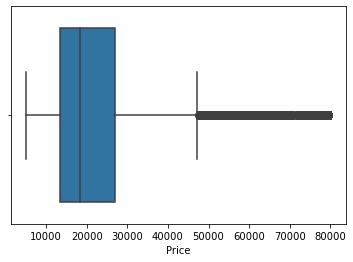

In [18]:
## Se procede a verificar si existen outliers de la variable precio

# Crear el boxplot
sns.boxplot(x=train_df["Price"])

# Calcular el conteo de outliers
q1, q3 = train_df["Price"].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = train_df[(train_df["Price"] < lower_bound) | (train_df["Price"] > upper_bound)]["Price"].count()

# Imprimir el conteo de outliers
print("Conteo de outliers: ", outliers)


# Mostrar el boxplot
plt.show()

Como se puede observar se cuenta con un número de 10.880 outliers comparado con el total de datos que se dispone de 400.000 es equivalente al 2,72% del total de datos. 

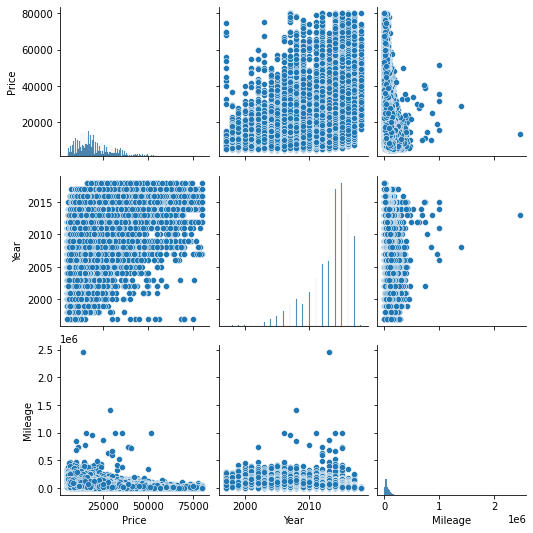

In [21]:
## Se procede a realizar un pairplot entre Price y las variables Númericas
sns.pairplot(train_df[["Price", "Year", "Mileage"]])

Se puede observar que existe una leve relación entre los precios y los Años y Millas. Mientras más reciente sea el año mayor el Precio y mientras más Millas menor el Precio. Esto puede estar demarcando una correlación importante. 

### Preprocesamiento de Datos

In [2]:
### cambios
directorio = os.path.split(os.getcwd())[0]
test_df = pd.read_csv(os.path.join("../INPUT/","dataTest_carListings.csv"))
train_df = pd.read_csv(os.path.join("../INPUT/","dataTrain_carListings.csv"))

## Se realiza la verificación de que no haya datos faltantes

missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()

results_train = pd.DataFrame({'Column': missing_values_train.index, 'Missing Values': missing_values_train.values})
results_test = pd.DataFrame({'Column': missing_values_test.index, 'Missing Values': missing_values_test.values})

print(results_train)
print(results_test)

    Column  Missing Values
0    Price               0
1     Year               0
2  Mileage               0
3    State               0
4     Make               0
5    Model               0
    Column  Missing Values
0       ID               0
1     Year               0
2  Mileage               0
3    State               0
4     Make               0
5    Model               0


In [5]:
directorio = os.path.split(os.getcwd())[0]
test_df = pd.read_csv(os.path.join("../INPUT/","dataTest_carListings.csv"))
train_df = pd.read_csv(os.path.join("../INPUT/","dataTrain_carListings.csv"))

X_train = train_df.iloc[:,1:]
X_test = test_df.iloc[:,1:]
y_train = train_df.iloc[:,0]
y_test = test_df.iloc[:,0]

X_train

,Year,Mileage,State,Make,Model
0,2017,9913,FL,Jeep,Wrangler
1,2015,20578,OH,Chevrolet,Tahoe4WD
2,2012,83716,TX,BMW,X5AWD
3,2014,28729,OH,Cadillac,SRXLuxury
4,2013,64032,CO,Jeep,Wrangler
...,...,...,...,...,...
399995,2015,25287,TX,Lexus,RXRX
399996,2015,17677,MI,Chevrolet,EquinoxFWD
399997,2014,66688,NC,Buick,EnclaveLeather
399998,2014,37872,IN,Volkswagen,Jetta


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time

# Train the model without parallelization
params = {'objective': 'multi:softmax', 'num_class': 7, 'n_jobs': 1}

print("Training model without parallelization.")
start_time = time.time()
model = xgb.train(params, xgb.DMatrix(X_train, label=y_train))
elapsed_time_no_parallel = time.time() - start_time

# Train the model with parallelization
params_parallel = {'objective': 'multi:softmax', 'num_class': 7, 'n_jobs': -1}

print("Training model with parallelization.")
start_time_parallel = time.time()
model_parallel = xgb.train(params_parallel, xgb.DMatrix(X_train, label=y_train))
elapsed_time_parallel = time.time() - start_time_parallel

# Print the time comparisons
print(f"Training time without parallelization: {elapsed_time_no_parallel:.2f} seconds")
print(f"Training time with parallelization: {elapsed_time_parallel:.2f} seconds")


Training model with parallelization.


AttributeError: module 'xgboost' has no attribute 'train'